In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [2]:
import hax
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.colors import LogNorm
from collections import defaultdict
from array import array
import pylab
from hax import cuts

# Machine Learning and Single Scatters

## Motivation:
* Learn some algorithms of scikit-learn
* Apply some of them to calibration data to construct a decision model
* See how well some learning classes of scikit-learn could work to a ss cut


## Going to
* Compare training a RandomForest on AmBe and Rn data with linear SS cut and without

In [3]:
# import data samples and run names

rn_samp = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_rn_event_combine/170313_1055.pkl')
ng_samp = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_ng_event_combine/170524_1451.pkl')
ambe_samp = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_ambe_event_combine/170316_0834.pkl')

rn_run_names = pd.read_pickle('/home/shawaf/calibration_data/run_names_v6.6.5_rn.pkl')
ng_run_names = pd.read_pickle('/home/shawaf/calibration_data/run_names_v6.6.5_ng.pkl')
ambe_run_names = pd.read_pickle('/home/shawaf/calibration_data/run_names_v6.6.5_ambe.pkl')

In [4]:
def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

In [5]:
# Create dataframes with all rn, ng, ambe
import os

ng = pd.DataFrame(columns = list(ng_samp))
rn = pd.DataFrame(columns = list(rn_samp))
ambe = pd.DataFrame(columns = list(ambe_samp))

for filename in os.listdir('/home/shawaf/calibration_data/pax_v6.6.5_ng_event_combine/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_ng_event_combine/' + str(filename))
    ng = ng.append(df)
    
for filename in os.listdir('/home/shawaf/calibration_data/pax_v6.6.5_rn_event_combine/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_rn_event_combine/' + str(filename))
    rn = rn.append(df)

for filename in os.listdir('/home/shawaf/calibration_data/pax_v6.6.5_ambe_event_combine/'):
    df = pd.read_pickle('/home/shawaf/calibration_data/pax_v6.6.5_ambe_event_combine/' + str(filename))
    ambe = ambe.append(df)
    
nng = ng
rambe = ambe
rrn = rn

In [6]:
# assigning classes based on which calibration data

ambe['class'] = 0
ng['class'] = 1
rn['class'] = 2

rambe['class'] = 0
nng['class'] = 1
rrn['class'] = 2

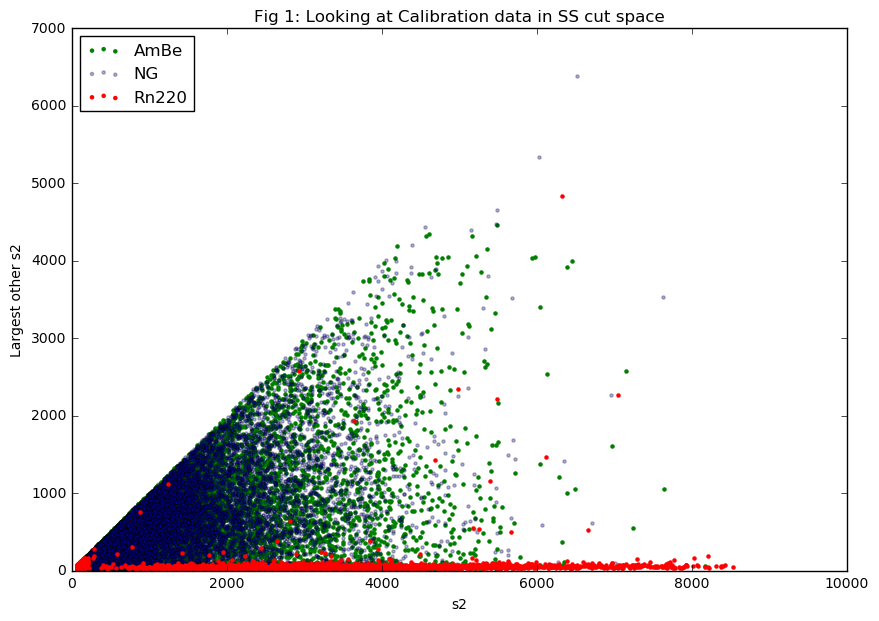

In [7]:
plt.figure(figsize=(10,7))
plt.scatter(ambe["s2"],ambe["s2_1_area"],color='green',marker='.', alpha=1,label='AmBe')
plt.scatter(ng["s2"], ng["s2_1_area"],marker='.', alpha = 0.3,label='NG')
plt.scatter(rn["s2"], rn["s2_1_area"],color='r',marker='.',label="Rn220")

plt.title("Fig 1: Looking at Calibration data in SS cut space")

plt.xlabel("s2")
plt.ylabel("Largest other s2")

plt.legend(loc='upper left')

plt.xlim(0,10000)
plt.ylim(0,7000)
plt.show()

### So, can see that the Rn data are not all ideal single scatters and the AmBe data can't all be ideal MS.  Can cut the data to purify the training samples. Taking the linear cut in this space from Tianyu's "prospective s2 single scatter cut". Not sure what cuts the data has gone through up to this point?

### Going to train on Rn and AmBe data after the linear cut, will test on NG data. Know Rn is mostly single scatters, and low-E AmBe should be mostly MS?

### There's a tradeoff here if I use this linear cut:
* The training data would now be classified as:
#### class 1 : Rn and w/in cut - call Rn/SS
#### class 2 : AmBe and not w/in cut - call AmBe/MS
#####  
* This may contaminate the learning too much. When training, the algorithms would just try to converge on this cut in this space. How much this occurs can be quantified after, though. 

* If I don't use this cut, the best I am doing is training a machine to classify NG data as either AmBe or Rn. With cut, I get the linear cut AND the algorithm applied to all the other relevant features of the data.

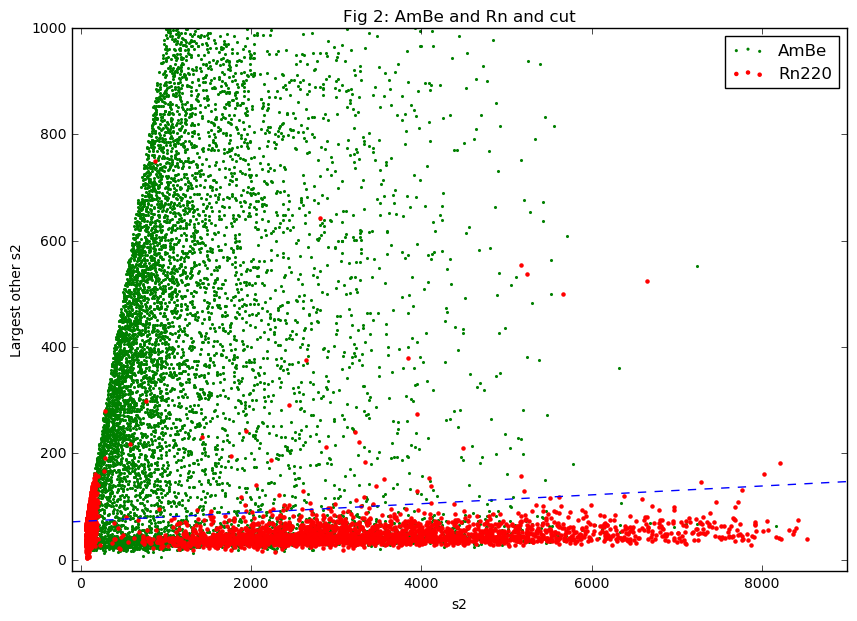

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(rambe["s2"],rambe["s2_1_area"],color='green',marker='.', lw=0, alpha=1,label='AmBe')
plt.scatter(rrn["s2"], rrn["s2_1_area"],color='r',marker='.',label="Rn220")

plt.title("Fig 2: AmBe and Rn and cut")

x = np.linspace(-100,10000,10000)
plt.plot(x,ses2_size_cut_ori(x),linestyle='--')

plt.xlabel("s2")
plt.ylabel("Largest other s2")

plt.legend(loc='upper right')

plt.xlim(-100,9000)
plt.ylim(-20,1000)
plt.show()

In [9]:
# using linear cut in s2, largest other s2, described later

ambe = ambe[ambe["s2_1_area"] >= ses2_size_cut_ori(ambe["s2"])]
rn = rn[rn["s2_1_area"] <= ses2_size_cut_ori(rn["s2"])]

In [10]:
rrn['s1']

800         3.717522
1436      128.787750
5101       14.611032
7710       97.480339
8418      423.706482
10168     452.072540
11990      21.506815
22659      38.801846
27269       9.983695
30317     123.113213
32360      72.456818
33301       8.347945
36195       1.857215
39246      36.469082
39746      15.590198
9384       69.902214
10700     494.412781
15247      15.263326
23361      23.196438
183        14.086983
1143       11.558157
2751       99.636703
3771       36.267895
4217       23.365192
4595      325.394775
6970        6.620612
7168       60.156300
7338       53.167625
9632      133.221237
11002      16.259302
             ...    
89764       5.275923
90774      46.471798
95000      19.977549
97036      76.480629
101010     22.113924
104026    166.225052
105328    129.801910
105800      4.610411
106904      6.203793
108198     12.852721
108222      7.485845
108662     21.812435
108806     31.024307
109369     25.858562
111585     21.777817
112003     29.769480
113454     66

In [11]:
nrdf = rambe.append(rrn)
ndf = ambe.append(rn)
ndf.dropna(how='all');

In [12]:
# deciding what to put in the NaN's. Although I drop most of these features. There's got to be a better way to do this

nafill = pd.DataFrame({'class' : 0.0,
 'cs1' : 0.0,
 'cs2': 0.0,
 'drift_time': 0.0,
 'event_number': 0.0,
 'run_number': 0.0,
 's1': 0.0,
 's1_area_fraction_top': 0.0,
 's1_pattern_fit': 0.0,
 's1_range_50p_area': 0.0,
 's1_rise_time': 0.0,
 's2': 0.0,
 's2_1_area': 0.0,
 's2_1_area_fraction_top': 0.0,
 's2_1_corrected_area': 0.0,
 's2_1_delay_is1': 0.0,
 's2_1_delay_is2': 0.0,
 's2_1_range_50p_area': 0.0,
 's2_1_x': 1000.0,
 's2_1_y': 1000.0,
 's2_1_z': 1000.0,
 's2_2_area': 0.0,
 's2_2_area_fraction_top': 0.0,
 's2_2_corrected_area': 0.0,
 's2_2_delay_is1': 0.0,
 's2_2_delay_is2': 0.0,
 's2_2_range_50p_area': 0.0,
 's2_2_x': 1000.0,
 's2_2_y': 1000.0,
 's2_2_z': 1000.0,
 's2_3_area': 0.0,
 's2_3_area_fraction_top': 0.0,
 's2_3_corrected_area': 0.0,
 's2_3_delay_is1': 0.0,
 's2_3_delay_is2': 0.0,
 's2_3_range_50p_area': 0.0,
 's2_3_x': 1000.0,
 's2_3_y': 1000.0,
 's2_3_z': 1000.0,
 's2_4_area': 0.0,
 's2_4_area_fraction_top': 0.0,
 's2_4_corrected_area': 0.0,
 's2_4_delay_is1': 0.0,
 's2_4_delay_is2': 0.0,
 's2_4_range_50p_area': 0.0,
 's2_4_x': 1000.0,
 's2_4_y': 1000.0,
 's2_4_z': 1000.0,
 's2_5_area': 0.0,
 's2_5_area_fraction_top': 0.0,
 's2_5_corrected_area': 0.0,
 's2_5_delay_is1': 0.0,
 's2_5_delay_is2': 0.0,
 's2_5_range_50p_area': 0.0,
 's2_5_x': 1000.0,
 's2_5_y': 1000.0,
 's2_5_z': 1000.0,
 's2_area_fraction_top': 0.0,
 's2_pattern_fit': 0.0,
 's2_range_50p_area': 0.0,
 's2_rise_time': 0.0,
 'x': 1000.0,
 'y': 1000.0,
 'z': 1000.0}, index = [ndf.index])

ngnafill = pd.DataFrame({'class' : 0.0,
 'cs1' : 0.0,
 'cs2': 0.0,
 'drift_time': 0.0,
 'event_number': 0.0,
 'run_number': 0.0,
 's1': 0.0,
 's1_area_fraction_top': 0.0,
 's1_pattern_fit': 0.0,
 's1_range_50p_area': 0.0,
 's1_rise_time': 0.0,
 's2': 0.0,
 's2_1_area': 0.0,
 's2_1_area_fraction_top': 0.0,
 's2_1_corrected_area': 0.0,
 's2_1_delay_is1': 0.0,
 's2_1_delay_is2': 0.0,
 's2_1_range_50p_area': 0.0,
 's2_1_x': 1000.0,
 's2_1_y': 1000.0,
 's2_1_z': 1000.0,
 's2_2_area': 0.0,
 's2_2_area_fraction_top': 0.0,
 's2_2_corrected_area': 0.0,
 's2_2_delay_is1': 0.0,
 's2_2_delay_is2': 0.0,
 's2_2_range_50p_area': 0.0,
 's2_2_x': 1000.0,
 's2_2_y': 1000.0,
 's2_2_z': 1000.0,
 's2_3_area': 0.0,
 's2_3_area_fraction_top': 0.0,
 's2_3_corrected_area': 0.0,
 's2_3_delay_is1': 0.0,
 's2_3_delay_is2': 0.0,
 's2_3_range_50p_area': 0.0,
 's2_3_x': 1000.0,
 's2_3_y': 1000.0,
 's2_3_z': 1000.0,
 's2_4_area': 0.0,
 's2_4_area_fraction_top': 0.0,
 's2_4_corrected_area': 0.0,
 's2_4_delay_is1': 0.0,
 's2_4_delay_is2': 0.0,
 's2_4_range_50p_area': 0.0,
 's2_4_x': 1000.0,
 's2_4_y': 1000.0,
 's2_4_z': 1000.0,
 's2_5_area': 0.0,
 's2_5_area_fraction_top': 0.0,
 's2_5_corrected_area': 0.0,
 's2_5_delay_is1': 0.0,
 's2_5_delay_is2': 0.0,
 's2_5_range_50p_area': 0.0,
 's2_5_x': 1000.0,
 's2_5_y': 1000.0,
 's2_5_z': 1000.0,
 's2_area_fraction_top': 0.0,
 's2_pattern_fit': 0.0,
 's2_range_50p_area': 0.0,
 's2_rise_time': 0.0,
 'x': 1000.0,
 'y': 1000.0,
 'z': 1000.0}, index = [nng.index])

In [13]:
rnafill = pd.DataFrame({'class' : 0.0,
 'cs1' : 0.0,
 'cs2': 0.0,
 'drift_time': 0.0,
 'event_number': 0.0,
 'run_number': 0.0,
 's1': 0.0,
 's1_area_fraction_top': 0.0,
 's1_pattern_fit': 0.0,
 's1_range_50p_area': 0.0,
 's1_rise_time': 0.0,
 's2': 0.0,
 's2_1_area': 0.0,
 's2_1_area_fraction_top': 0.0,
 's2_1_corrected_area': 0.0,
 's2_1_delay_is1': 0.0,
 's2_1_delay_is2': 0.0,
 's2_1_range_50p_area': 0.0,
 's2_1_x': 1000.0,
 's2_1_y': 1000.0,
 's2_1_z': 1000.0,
 's2_2_area': 0.0,
 's2_2_area_fraction_top': 0.0,
 's2_2_corrected_area': 0.0,
 's2_2_delay_is1': 0.0,
 's2_2_delay_is2': 0.0,
 's2_2_range_50p_area': 0.0,
 's2_2_x': 1000.0,
 's2_2_y': 1000.0,
 's2_2_z': 1000.0,
 's2_3_area': 0.0,
 's2_3_area_fraction_top': 0.0,
 's2_3_corrected_area': 0.0,
 's2_3_delay_is1': 0.0,
 's2_3_delay_is2': 0.0,
 's2_3_range_50p_area': 0.0,
 's2_3_x': 1000.0,
 's2_3_y': 1000.0,
 's2_3_z': 1000.0,
 's2_4_area': 0.0,
 's2_4_area_fraction_top': 0.0,
 's2_4_corrected_area': 0.0,
 's2_4_delay_is1': 0.0,
 's2_4_delay_is2': 0.0,
 's2_4_range_50p_area': 0.0,
 's2_4_x': 1000.0,
 's2_4_y': 1000.0,
 's2_4_z': 1000.0,
 's2_5_area': 0.0,
 's2_5_area_fraction_top': 0.0,
 's2_5_corrected_area': 0.0,
 's2_5_delay_is1': 0.0,
 's2_5_delay_is2': 0.0,
 's2_5_range_50p_area': 0.0,
 's2_5_x': 1000.0,
 's2_5_y': 1000.0,
 's2_5_z': 1000.0,
 's2_area_fraction_top': 0.0,
 's2_pattern_fit': 0.0,
 's2_range_50p_area': 0.0,
 's2_rise_time': 0.0,
 'x': 1000.0,
 'y': 1000.0,
 'z': 1000.0}, index = [nrdf.index])

In [14]:
# counts2 = pd.DataFrame(df[['s2_1_area','s2_2_area', 's2_3_area', 's2_4_area']].count(axis=1), columns = ['counts2'])

### Choosing which features the classifier takes and filling NaN's

In [15]:
%%capture
keep = ['class','s2','s2_range_50p_area', 's2_1_x','s2_1_y','s2_2_x','s2_2_y','s2_3_x','s2_3_y','s2_4_x','s2_4_y',
        's2_1_z','s2_2_z','s2_3_z','s2_4_z',
        's2_1_delay_is2','s2_2_delay_is2','s2_3_delay_is2','s2_4_delay_is2',
        's2_1_range_50p_area', 's2_1_area',
       's2_2_range_50p_area', 's2_2_area',
       's2_3_range_50p_area', 's2_3_area',
       's2_4_range_50p_area', 's2_4_area']

todrop = ['s2_1_x','s2_1_y','s2_2_x','s2_2_y','s2_3_x','s2_3_y','s2_4_x','s2_4_y']

toadd = ['s2_1_r','s2_2_r','s2_3_r','s2_4_r']

# DataFrame after ss cut
df = ndf
df = ndf.fillna(value = nafill);
df = df[keep]

# DataFrame without ss linear cut
rdf = nrdf
rdf = nrdf.fillna(value = rnafill);
rdf = rdf[keep]

# NG data
ng = nng
ng = ng.fillna(value = ngnafill);
ng = ng[keep]
ng = ng[ng.s2>200]

# applying simple cuts and giving r values to all df's

keep = sorted(list((set(keep) - set(todrop)).union(set(toadd))))

df = df[df.s2>200]
df['s2_1_r'] = np.sqrt(df['s2_1_x']**2 + df['s2_1_y']**2)
df['s2_2_r'] = np.sqrt(df['s2_2_x']**2 + df['s2_2_y']**2)
df['s2_3_r'] = np.sqrt(df['s2_3_x']**2 + df['s2_3_y']**2)
df['s2_4_r'] = np.sqrt(df['s2_4_x']**2 + df['s2_4_y']**2)

df = df[keep]

rdf = rdf[rdf.s2>200]
rdf['s2_1_r'] = np.sqrt(rdf['s2_1_x']**2 + rdf['s2_1_y']**2)
rdf['s2_2_r'] = np.sqrt(rdf['s2_2_x']**2 + rdf['s2_2_y']**2)
rdf['s2_3_r'] = np.sqrt(rdf['s2_3_x']**2 + rdf['s2_3_y']**2)
rdf['s2_4_r'] = np.sqrt(rdf['s2_4_x']**2 + rdf['s2_4_y']**2)

rdf = rdf[keep]

ng = ng[ng.s2>200]
ng['s2_1_r'] = np.sqrt(ng['s2_1_x']**2 + ng['s2_1_y']**2)
ng['s2_2_r'] = np.sqrt(ng['s2_2_x']**2 + ng['s2_2_y']**2)
ng['s2_3_r'] = np.sqrt(ng['s2_3_x']**2 + ng['s2_3_y']**2)
ng['s2_4_r'] = np.sqrt(ng['s2_4_x']**2 + ng['s2_4_y']**2)

ng = ng[keep]


# add sum of lesser s2 areas and counts of the s2?
# sums2 = pd.DataFrame(df[['s2_2_area', 's2_3_area', 's2_4_area']].sum(axis=1), columns = ['s2sum'])
# df['sum_lesser_s2_area'] = sums2
# df['counts2'] = counts2

In [16]:
print("keeping",keep)

keeping ['class', 's2', 's2_1_area', 's2_1_delay_is2', 's2_1_r', 's2_1_range_50p_area', 's2_1_z', 's2_2_area', 's2_2_delay_is2', 's2_2_r', 's2_2_range_50p_area', 's2_2_z', 's2_3_area', 's2_3_delay_is2', 's2_3_r', 's2_3_range_50p_area', 's2_3_z', 's2_4_area', 's2_4_delay_is2', 's2_4_r', 's2_4_range_50p_area', 's2_4_z', 's2_range_50p_area']


In [17]:
# import sklearn

from sklearn.cross_validation import train_test_split
X, y = df.iloc[:,1:].values, df.iloc[:,0].values
rX, ry = rdf.iloc[:,1:].values, rdf.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
rX_train, rX_test, ry_train, ry_test = train_test_split(rX, ry, test_size=0.1, random_state=0)

/home/shawaf/anaconda3/envs/pax/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Fitting the Random Forests

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [19]:
rfc1 = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
rfc1.fit(rX_train, ry_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [20]:
%%capture
feat_labels = df.columns[1:]

importances = rfc.feature_importances_
indicies = np.argsort(importances)[::-1]
for f in  range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[indicies[f]],
                           importances[indicies[f]]))
    
rfeat_labels = rdf.columns[1:]

rimportances = rfc1.feature_importances_
rindicies = np.argsort(rimportances)[::-1]
for f in  range(rX_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           rfeat_labels[rindicies[f]],
                           rimportances[rindicies[f]]))

In [21]:
print("With cut, RandomForest test score is:" ,rfc.score(X_test, y_test))
print("Without cut, RandomForest test score is:" ,rfc1.score(rX_test, ry_test))

With cut, RandomForest test score is: 0.998661759786
Without cut, RandomForest test score is: 0.896899224806


## How important each feature is in each classifier

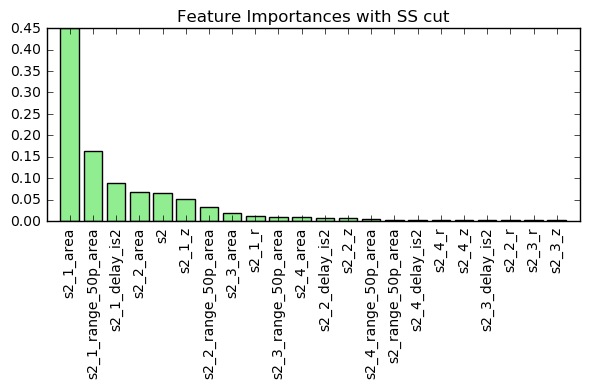

In [22]:
plt.title('Feature Importances with SS cut')
plt.bar(range(X_train.shape[1]),
       importances[indicies],
       color='lightgreen',
       align = 'center')
plt.xticks(range(X_train.shape[1]),
          feat_labels[indicies], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

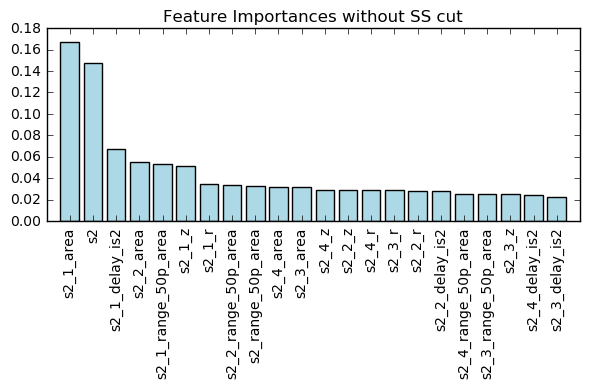

In [23]:
plt.title('Feature Importances without SS cut')
plt.bar(range(rX_train.shape[1]),
       rimportances[rindicies],
       color='lightblue',
       align = 'center')
plt.xticks(range(rX_train.shape[1]),
          rfeat_labels[rindicies], rotation=90)
plt.xlim([-1, rX_train.shape[1]])
plt.tight_layout()
plt.show()

In [24]:
y_pred = rfc.predict(X_test)
ry_pred = rfc1.predict(rX_test)

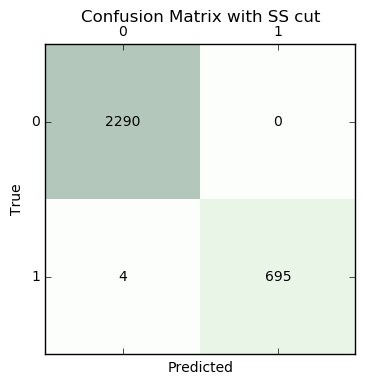

In [25]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
rconfmat = confusion_matrix(y_true=ry_test, y_pred=ry_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Greens, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.title('Confusion Matrix with SS cut')

plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

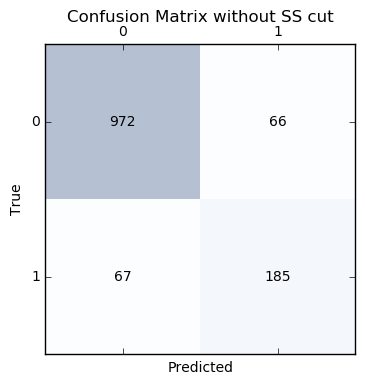

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(rconfmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(rconfmat.shape[0]):
    for j in range(rconfmat.shape[1]):
        ax.text(x=j, y=i, s=rconfmat[i, j], va='center', ha='center')
        

plt.title('Confusion Matrix without SS cut')

plt.xlabel('Predicted')
plt.ylabel('True')
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

In [27]:
a = rfc.predict(np.array(ng)[:,1:])
ra =  rfc1.predict(np.array(ng)[:,1:])

In [28]:
b = np.unique(a, return_counts=True)
sm = b[1][0] + b[1][1]
print("RandomForest applied to NG data with cut. \n Proportion classified as AmBe/MS: %s \n Proportion classified as Rn/SS: %s " % (str(b[1][0]/sm),str(b[1][1]/sm)))

RandomForest applied to NG data with cut. 
 Proportion classified as AmBe/MS: 0.762837934487 
 Proportion classified as Rn/SS: 0.237162065513 


In [29]:
rb = np.unique(ra, return_counts=True)
rsm = rb[1][0] + rb[1][1]
print("RandomForest applied to NG data without cut. \n Proportion classified as AmBe/MS: %s \n Proportion classified as Rn/SS: %s " % (str(rb[1][0]/rsm),str(rb[1][1]/rsm)))

RandomForest applied to NG data without cut. 
 Proportion classified as AmBe/MS: 0.943355743098 
 Proportion classified as Rn/SS: 0.0566442569017 


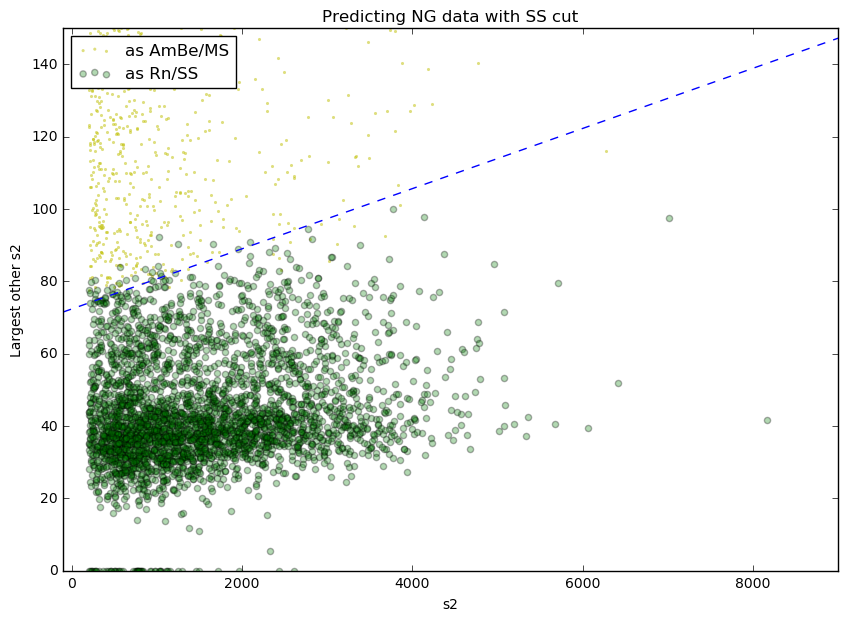

Number of NG data predicted as AmBe/MS within SS cut: 19
Number of NG data predicted as Rn/SS outside SS cut: 28


In [30]:
ng['predicted_class'] = a
plt.figure(figsize=(10,7))

plt.scatter(ng[ng['predicted_class'] == 0]["s2"],ng[ng['predicted_class'] == 0]["s2_1_area"],
            c='y', marker = '.', lw=0 , alpha = .5, label = "as AmBe/MS")
plt.scatter(ng[ng['predicted_class'] == 2]["s2"],ng[ng['predicted_class'] == 2]["s2_1_area"],
            c='g', marker = 'o', alpha = .3,label = "as Rn/SS")


x = np.linspace(-100,10000,10000)
plt.plot(x,ses2_size_cut_ori(x),linestyle='--')

plt.xlim(-100,9000)
plt.ylim(0,150)

plt.title("Predicting NG data with SS cut")
plt.xlabel("s2")
plt.ylabel("Largest other s2")

plt.legend(loc='upper left')
plt.show()

r = ng[(ng['predicted_class'] == 0) & (ng['s2_1_area'] <= ses2_size_cut_ori(ng['s2']))]['class'].count()
q = ng[(ng['predicted_class'] == 2) & (ng['s2_1_area'] >= ses2_size_cut_ori(ng['s2']))]['class'].count()

print('Number of NG data predicted as AmBe/MS within SS cut:',r)
print('Number of NG data predicted as Rn/SS outside SS cut:',q)

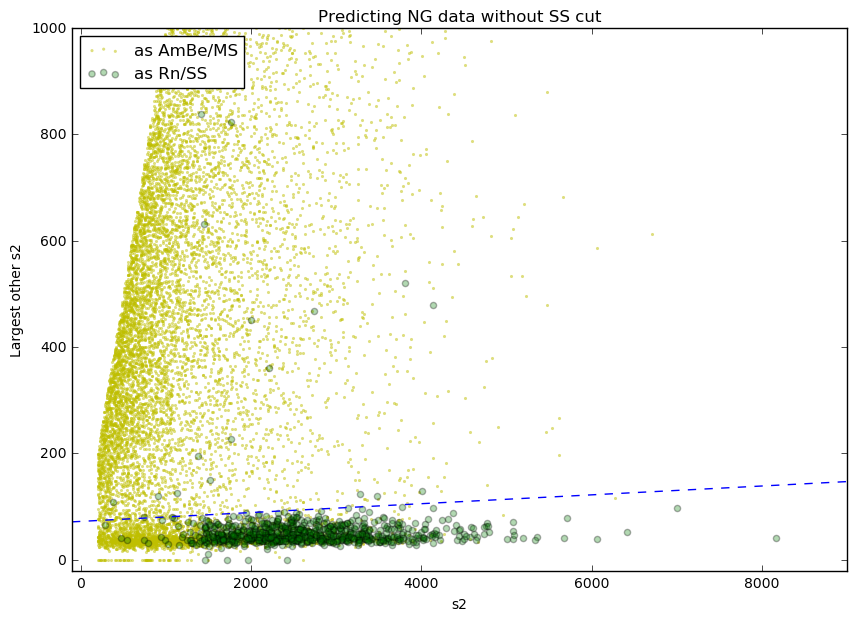

Number of NG data predicted as AmBe/MS below cut: 2536
Number of NG data predicted as Rn/SS above cut: 21


In [32]:
ng['predicted_class'] = ra
plt.figure(figsize=(10,7))

plt.scatter(ng[ng['predicted_class'] == 0]["s2"],ng[ng['predicted_class'] == 0]["s2_1_area"],
            c='y', marker = '.', lw=0 , alpha = .5, label = "as AmBe/MS")
plt.scatter(ng[ng['predicted_class'] == 2]["s2"],ng[ng['predicted_class'] == 2]["s2_1_area"],
            c='g', marker = 'o', alpha = .3,label = "as Rn/SS")


x = np.linspace(-100,10000,10000)
plt.plot(x,ses2_size_cut_ori(x),linestyle='--')

plt.xlim(-100,9000)
plt.ylim(-20,1000)

plt.title("Predicting NG data without SS cut")
plt.xlabel("s2")
plt.ylabel("Largest other s2")

plt.legend(loc='upper left')
plt.show()

r = ng[(ng['predicted_class'] == 0) & (ng['s2_1_area'] <= ses2_size_cut_ori(ng['s2']))]['class'].count()
q = ng[(ng['predicted_class'] == 2) & (ng['s2_1_area'] >= ses2_size_cut_ori(ng['s2']))]['class'].count()
print('Number of NG data predicted as AmBe/MS below cut:',r)
print('Number of NG data predicted as Rn/SS above cut:',q)

In [33]:
y_pred_proba = rfc.predict_proba(np.array(ng.drop("predicted_class",1))[:,1:])
ry_pred_proba = rfc1.predict_proba(np.array(ng.drop("predicted_class",1))[:,1:])

## Truncated at ends b/c scaling, amount of ambiguity:

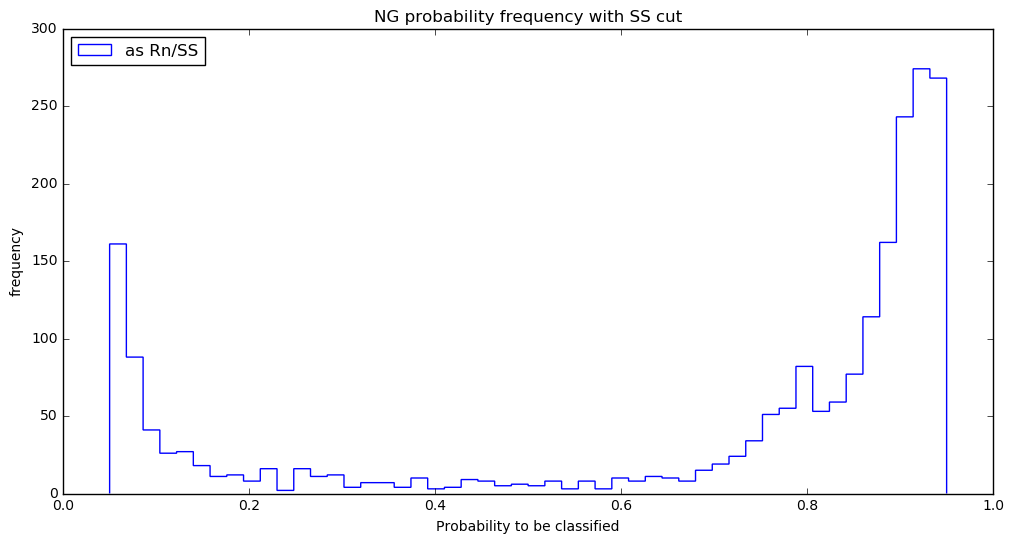

In [34]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.hist(y_pred_proba.T[1], bins = 50,histtype = 'step', linestyle = 'solid',range = (0.05,.95),label = 'as Rn/SS')

plt.legend(loc='upper left')
plt.xlabel('Probability to be classified')
plt.ylabel('frequency')
plt.title('NG probability frequency with SS cut')
plt.show()

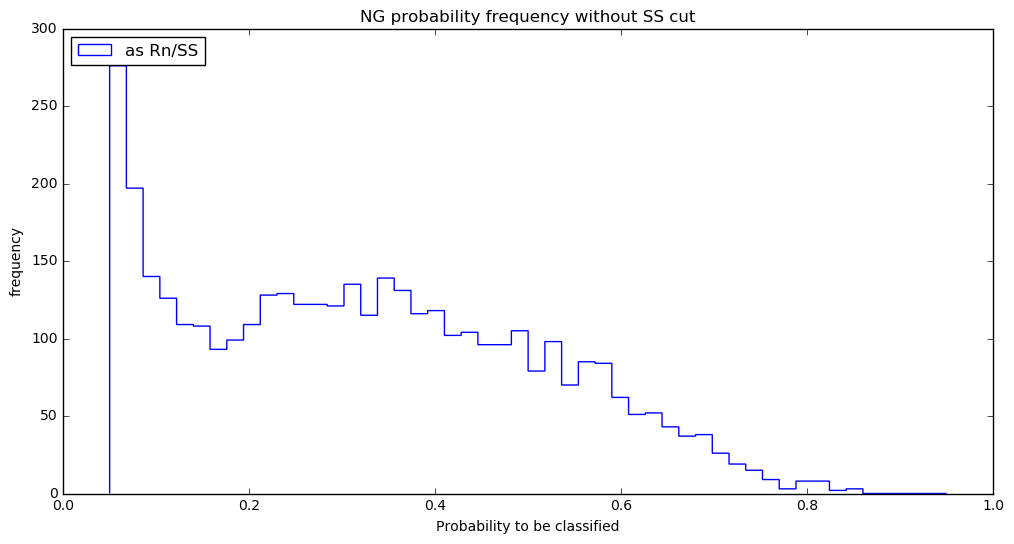

In [35]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.hist(ry_pred_proba.T[1], bins = 50,histtype = 'step', linestyle = 'solid',range = (0.05,.95),label = 'as Rn/SS')

plt.legend(loc='upper left')
plt.xlabel('Probability to be classified')
plt.ylabel('frequency')
plt.title('NG probability frequency without SS cut')
plt.show()

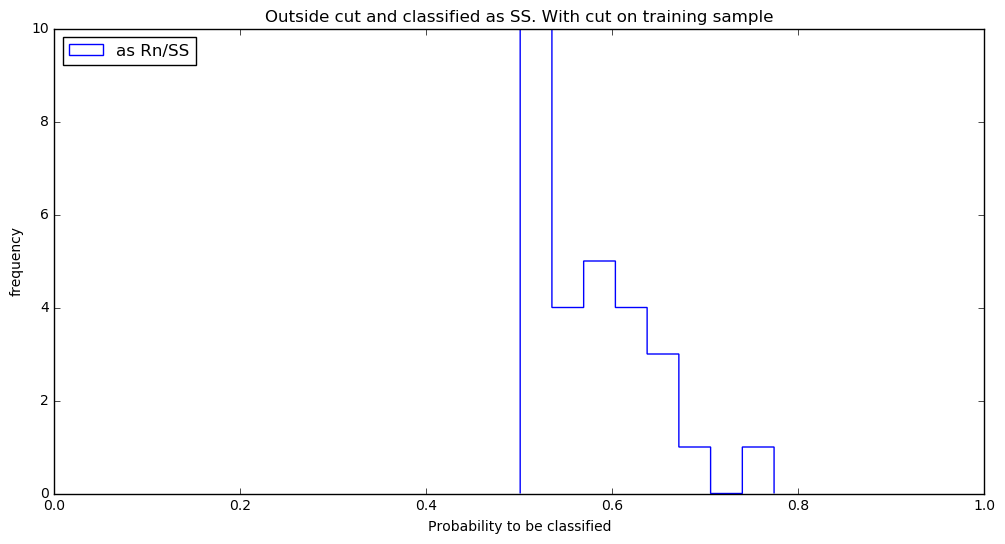

In [36]:
ng['predicted_class'] = a
fp = ng[(ng['predicted_class'] == 2) & (ng['s2_1_area'] >= ses2_size_cut_ori(ng['s2']))]
del fp['predicted_class']

fpp = rfc.predict_proba(np.array(fp)[:,1:])

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.hist(fpp.T[1], bins = 8,histtype = 'step', linestyle = 'solid',label = 'as Rn/SS')

plt.xlim(0,1)

plt.legend(loc='upper left')
plt.xlabel('Probability to be classified')
plt.ylabel('frequency')
plt.title('Outside cut and classified as SS. With cut on training sample')
plt.show()

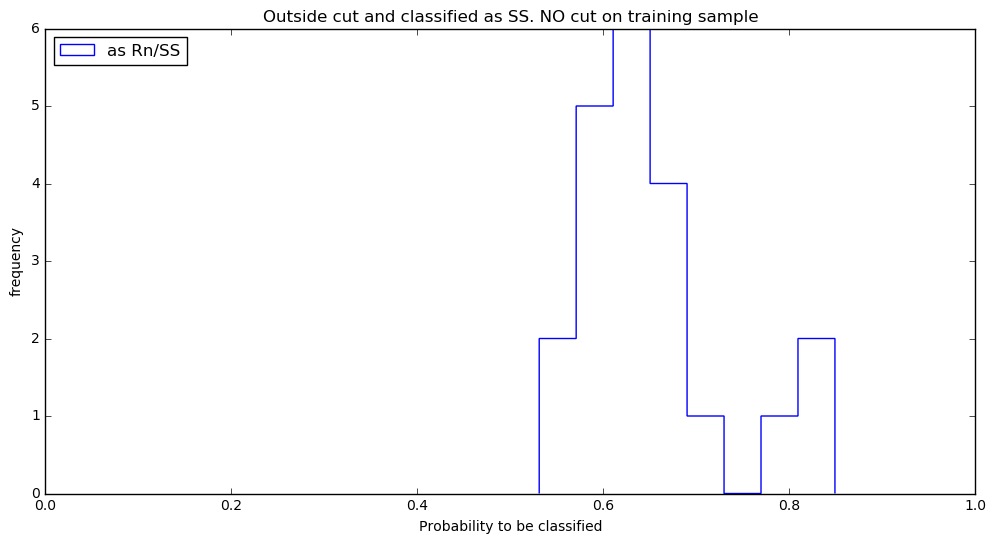

In [37]:
ng['predicted_class'] = ra

fp = ng[(ng['predicted_class'] == 2) & (ng['s2_1_area'] >= ses2_size_cut_ori(ng['s2']))]
del fp['predicted_class']

fpp = rfc1.predict_proba(np.array(fp)[:,1:])

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.hist(fpp.T[1], bins = 8,histtype = 'step', linestyle = 'solid',label = 'as Rn/SS')

plt.xlim(0,1)

plt.legend(loc='upper left')
plt.xlabel('Probability to be classified')
plt.ylabel('frequency')
plt.title('Outside cut and classified as SS. NO cut on training sample')
plt.show()

In [38]:
u = y_pred_proba.T[1]
v = ((u>.2)&(u<.8)).sum()
print("With SS cut: Amount of events with probabilities to be classified between 20% and 80%:", v)

With SS cut: Amount of events with probabilities to be classified between 20% and 80%: 463


In [39]:
u = ry_pred_proba.T[1]
v = ((u>.2)&(u<.8)).sum()
print("Without SS cut: Amount of events with probabilities to be classified between 20% and 80%:", v)

Without SS cut: Amount of events with probabilities to be classified between 20% and 80%: 2726


## Conclusions
* Seems to classify NG confidently with SS cut in training data, and not so much without it.
* Need to have better methods of preparing data and classifying the training set according to MS and SS, so the randomforest is learning something more significant
* I learned so much!

## Possible things to do

* Figure out best way to prepare the data with more assurance that it is SS and MS
* make SS, MS in fax to test classifiers once trained on purer ss, ms